#ML DL Project 2 (Main)#
##Unsupervised Learning (Clustering)##
###Activities of Daily Living Recognition Using Binary Sensors Data Set###
This dataset comprises information regarding the ADLs performed by two users on a daily basis in their
own homes. This dataset is composed by two instances of data, each one corresponding to a different
user and summing up to 35 days of fully labeled data. Each instance of the dataset is described by three
text files, namely: description, sensors’ events (features), and activities of daily living (labels). Sensor
events were recorded using a wireless sensor network and data were labeled manually.
Based on the dataset, you need to build your own clustering model as unsupervised learning to divide the
clusters without the label information. In order to apply the clustering method, you also need to apply
feature extraction as a preprocessing. After finishing the clustering, you need to evaluate the clustering
performance using the labels (ADL). You can use any unsupervised learning techniques, but you should
not use supervised learning methodologies.


In [1]:
# -----------------------------
# CORE PYTHON LIBRARIES
import os
from collections import Counter            # Element frequency
from itertools import islice, tee          # Sliding window utilities
from scipy.stats import entropy, mode      # Statistical measures

# -----------------------------
# DATA HANDLING
import pandas as pd                        # DataFrame operations
import numpy as np                         # Numerical computing

# -----------------------------
# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Plot aesthetics
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

# -----------------------------
# FEATURE SCALING & ENCODING
from sklearn.preprocessing import StandardScaler   # Standardization
from sklearn.preprocessing import LabelEncoder     # Label encoding for categorical values

# -----------------------------
# DIMENSIONALITY REDUCTION
from sklearn.decomposition import PCA              # Principal Component Analysis
from sklearn.manifold import TSNE                  # t-SNE for 2D/3D visualization

# -----------------------------
# CLUSTERING ALGORITHMS
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering     # Hierarchical Clustering
)

# -----------------------------
# CLUSTERING EVALUATION METRICS
from sklearn.metrics import (
    silhouette_score,                   # Average silhouette width
    silhouette_samples,                 # Per-sample silhouette
    calinski_harabasz_score,           # Between vs. within-cluster dispersion
    davies_bouldin_score,              # Intra/inter-cluster similarity (lower is better)
    adjusted_rand_score,               # ARI: external clustering validation
    normalized_mutual_info_score,      # Mutual information between true/predicted
    homogeneity_score,                 # Homogeneity metric
    completeness_score,                # Completeness metric
    v_measure_score,                   # Harmonic mean of homogeneity & completeness
    confusion_matrix                   # True label vs predicted label comparison
)

# -----------------------------
# CONFUSION MATRIX DISPLAY
from sklearn.metrics import ConfusionMatrixDisplay

# -----------------------------
# GOOGLE COLAB SETUP
from google.colab import drive
drive.mount('/content/drive')  # Mount your Google Drive to access dataset/files

# -----------------------------
# FILE & DATASET PATH SETUP
base_path = '/content/drive/MyDrive/UCI ADL Binary Dataset/'  # Change if dataset moves


Mounted at /content/drive


# Step 1: Loading Dataset

In [2]:
# This function is used to  load and structure raw ADL or sensor logs into a usable format for further analysis.
#  Converts the extracted data into a structured pandas DataFrame.
def data_loader(file_path, file_type='sensor'):
        parsed_data = []
        with open(file_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            line = line.strip()
            if not line or line.lower().startswith("start time") or line.startswith("-"):
                continue

            parts = line.split()
            if file_type == 'sensor' and len(parts) >= 6:
                start_time = pd.to_datetime(f"{parts[0]} {parts[1]}")
                end_time = pd.to_datetime(f"{parts[2]} {parts[3]}")
                location = parts[4]
                type_ = parts[5]
                place = parts[6] if len(parts) > 6 else ''
                parsed_data.append([start_time, end_time, location, type_, place])
            elif file_type == 'adl' and len(parts) >= 5:
                start_time = pd.to_datetime(f"{parts[0]} {parts[1]}")
                end_time = pd.to_datetime(f"{parts[2]} {parts[3]}")
                activity = ' '.join(parts[4:])
                parsed_data.append([start_time, end_time, activity])

        if file_type == 'sensor':
            return pd.DataFrame(parsed_data, columns=['start_datetime', 'end_datetime', 'location', 'type', 'place'])
        elif file_type == 'adl':
            return pd.DataFrame(parsed_data, columns=['start_datetime', 'end_datetime', 'activity'])


In [3]:
print("Loading datasets...")

# Sensor data
sensors_a = data_loader(base_path + 'OrdonezA_Sensors.txt', 'sensor')
sensors_b = data_loader(base_path + 'OrdonezB_Sensors.txt', 'sensor')

# ADL data
adls_a = data_loader(base_path + 'OrdonezA_ADLs.txt', 'adl')
adls_b = data_loader(base_path + 'OrdonezB_ADLs.txt', 'adl')

# Summary
print(f"=> User A - {len(sensors_a)} sensor events")
print(f"=> User B - {len(sensors_b)} sensor events")
print(f"=> User A - {len(adls_a)} ADL annotations")
print(f"=> User B - {len(adls_b)} ADL annotations")


Loading datasets...
=> User A - 409 sensor events
=> User B - 2334 sensor events
=> User A - 248 ADL annotations
=> User B - 493 ADL annotations


In [4]:
print("Sensor A:\n", sensors_a.head(), "\n")
print("ADL A:\n", adls_a.head(), "\n")

print("Sensor B:\n", sensors_b.head(), "\n")
print("ADL B:\n", adls_b.head())


Sensor A:
        start_datetime        end_datetime location      type     place
0 2011-11-28 02:27:59 2011-11-28 10:18:11      Bed  Pressure   Bedroom
1 2011-11-28 10:21:24 2011-11-28 10:21:31  Cabinet  Magnetic  Bathroom
2 2011-11-28 10:21:44 2011-11-28 10:23:31    Basin       PIR  Bathroom
3 2011-11-28 10:23:02 2011-11-28 10:23:36   Toilet     Flush  Bathroom
4 2011-11-28 10:25:44 2011-11-28 10:32:06   Shower       PIR  Bathroom 

ADL A:
        start_datetime        end_datetime   activity
0 2011-11-28 02:27:59 2011-11-28 10:18:11   Sleeping
1 2011-11-28 10:21:24 2011-11-28 10:23:36  Toileting
2 2011-11-28 10:25:44 2011-11-28 10:33:00  Showering
3 2011-11-28 10:34:23 2011-11-28 10:43:00  Breakfast
4 2011-11-28 10:49:48 2011-11-28 10:51:13   Grooming 

Sensor B:
        start_datetime        end_datetime location      type    place
0 2012-11-11 21:14:21 2012-11-12 00:21:49     Seat  Pressure   Living
1 2012-11-12 00:22:57 2012-11-12 00:22:59     Door       PIR   Living
2 2012-11-12

# Step 2: Feature Extraction
This step is a crucial step in preparing raw data for machine learning, particularly in the context of unsupervised learning tasks like clustering. The purpose of feature extraction is to transform raw input data into a set of meaningful features that are more suitable for analysis. Here the raw data consists of timestamps and sensor readings, which need to be transformed into a form that can reveal patterns of user activity. The extracted features, such as sensor counts over time windows, allow clustering algorithms to identify and group similar activity patterns (e.g., Sleeping, Watching TV, or walking) from the sensor events. This transformation is crucial for clustering activities of daily living (ADLs) based on sensor data, which in turn helps in recognizing patterns of behavior, detecting anomalies, and understanding daily routines. This step is particularly important for a dataset like OrdonezA and OrdonezB, where labeled data is provided, and unsupervised learning techniques are used to group or classify activities without using the labels.

In order to extract meaningful behavioral patterns from the sensor data for clustering, the following feature transformations are applied:
1. **Datetime Conversion & Time Windowing**:
The StartTime and EndTime columns are converted into datetime objects. Data is then grouped into 10-minute time windows by flooring the StartTime to the nearest 10-minute mark. This segmentation helps capture user behavior over short, consistent intervals.

2. **Global Transition Pattern Extraction**:
For each user and time window, a list of sequential locations is extracted. From these, all 2-location transitions (bigrams) are computed. The most frequent top N transitions globally are identified, which will later be tracked in each time window.

3. **Time-Based Aggregated Features**:
For every 10-minute window, several duration-based features are computed:

* Total, mean, max, min, and standard deviation of event durations.

* Count of events in the time window.

* Number of location transitions (changes in location from one event to the next).

* Location entropy, which measures the randomness or diversity of locations visited.

4. **Transition Frequency Features**:
For the top N most common global transitions (e.g., Kitchen → Bedroom), counts of how often they occur in each time window are included as additional features, capturing user movement trends.

5. **Temporal Context Features**:
Each time window is categorized into one of four broad time-of-day categories (night, morning, day, evening) and the weekday is extracted. This provides context for when certain behaviors occur.

6. **Sensor Usage Profile**:
Within each time window, the top 5 most frequently occurring values for Type, Place, and Location are identified. For each, both the absolute count and relative frequency (as a ratio of total events) are included as features, highlighting dominant sensor interactions.

7. **One-Hot Encoding of Time Categories**:
The time_category feature is one-hot encoded, ensuring that models can use this categorical information without imposing ordinal assumptions.

In [5]:
# -----------------------------
# Helper: N-gram Generator
# -----------------------------
def ngrams(lst, n=2):
    """
    Generates n-grams (e.g., pairs of locations) from a list.
    Used to extract location transitions.
    """
    return zip(*(islice(lst, i, None) for i in range(n)))

# -----------------------------
# Main Feature Extraction Function
# -----------------------------
def extract_transition_features(sensor_df, user_label, time_column='start_datetime', window_minutes=10, top_n_transitions=30):
    """
    Extracts transition and behavioral features from raw sensor logs.

    Parameters:
        sensor_df : pd.DataFrame
            DataFrame of parsed sensor logs.
        user_label : str
            Identifier for user (e.g., 'A', 'B', or 'A+B').
        time_column : str
            The datetime column to use for windowing (typically start time).
        window_minutes : int
            Duration of each time window for feature aggregation.
        top_n_transitions : int
            Number of most common location transitions to track as features.

    Returns:
        feature_matrix : pd.DataFrame
            DataFrame of extracted features per time window.
    """
    print(f"\n Extracting features for {user_label}...")

    # Create time window column (round timestamps down to nearest window)
    sensor_df['TimeWindow'] = sensor_df[time_column].dt.floor(f'{window_minutes}T')
    sensor_df['User'] = user_label

    # Step 1: Identify top N most common location transitions across all windows
    def top_transitions(df, N=20):
        all_transitions = []
        for _, group in df.groupby(['User', 'TimeWindow']):
            loc_list = group['location'].tolist()
            all_transitions.extend(ngrams(loc_list, 2))
        most_common = Counter(all_transitions).most_common(N)
        return set((a, b) for (a, b), _ in most_common)

    top_trans_set = top_transitions(sensor_df, N=top_n_transitions)

    records = []

    # Step 2: Extract features for each time window
    for (user, timewindow), group in sensor_df.groupby(['User', 'TimeWindow']):
        durations = (group['end_datetime'] - group['start_datetime']).dt.total_seconds()

        features = {
            'User': user,
            'TimeWindow': timewindow,
            'event_count': len(group),
            'duration_total': durations.sum(),
            'duration_mean': durations.mean(),
            'duration_std': durations.std(),
            'duration_max': durations.max(),
            'duration_min': durations.min(),
            'location_transitions': (group['location'] != group['location'].shift()).sum(),
        }

        # Entropy of location usage (higher = more diverse movement)
        loc_dist = group['location'].value_counts(normalize=True)
        features['location_entropy'] = entropy(loc_dist)

        # Transition feature counts (top N location pairs only)
        loc_list = group['location'].tolist()
        for (a, b) in ngrams(loc_list, 2):
            if (a, b) in top_trans_set:
                features[f"transition_{a}_to_{b}"] = features.get(f"transition_{a}_to_{b}", 0) + 1

        # Categorize by time-of-day
        hour = timewindow.hour
        if hour < 6:
            features['time_category'] = 'night'
        elif hour < 12:
            features['time_category'] = 'morning'
        elif hour < 18:
            features['time_category'] = 'day'
        else:
            features['time_category'] = 'evening'

        # Day of week (0=Monday, 6=Sunday)
        features['weekday'] = timewindow.weekday()

        # Top 5 frequent values for each metadata column (type, place, location)
        for col in ['type', 'place', 'location']:
            counts = group[col].value_counts()
            top_n = counts.nlargest(5)
            for k, v in top_n.items():
                features[f"{col.lower()}_{k}_count"] = v
                features[f"{col.lower()}_{k}_ratio"] = v / len(group)

        records.append(features)

    # Step 3: Convert to DataFrame and one-hot encode time-of-day
    feature_matrix_final = pd.DataFrame(records).fillna(0)
    feature_matrix = pd.get_dummies(feature_matrix_final, columns=['time_category'])

    print(f"-> Features extracted for {user_label}: {feature_matrix.shape[0]} windows, {feature_matrix.shape[1]} features")
    return feature_matrix


In [6]:
# Extracting features for each user
features_a = extract_transition_features(sensors_a, user_label='A')
features_b = extract_transition_features(sensors_b, user_label='B')

features_a.head()


 Extracting features for A...


<ipython-input-5-15344b8aad9a>:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sensor_df['TimeWindow'] = sensor_df[time_column].dt.floor(f'{window_minutes}T')


-> Features extracted for A: 200 windows, 89 features

 Extracting features for B...


<ipython-input-5-15344b8aad9a>:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sensor_df['TimeWindow'] = sensor_df[time_column].dt.floor(f'{window_minutes}T')


-> Features extracted for B: 660 windows, 85 features


,User,TimeWindow,event_count,duration_total,duration_mean,duration_std,duration_max,duration_min,location_transitions,location_entropy,...,transition_Toaster_to_Cupboard,transition_Fridge_to_Toaster,transition_Toaster_to_Microwave,transition_Fridge_to_Cooktop,transition_Basin_to_Maindoor,transition_Basin_to_Bed,time_category_day,time_category_evening,time_category_morning,time_category_night
0,A,2011-11-28 02:20:00,1,28212.0,28212.00,0.000000,28212.0,28212.0,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True
1,A,2011-11-28 10:20:00,4,530.0,132.50,171.612937,382.0,7.0,4,1.386294,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True,False
2,A,2011-11-28 10:30:00,4,459.0,114.75,129.193331,281.0,7.0,4,1.039721,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True,False
3,A,2011-11-28 10:40:00,4,164.0,41.00,36.249138,85.0,7.0,4,1.386294,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True,False
4,A,2011-11-28 10:50:00,1,8006.0,8006.00,0.000000,8006.0,8006.0,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True,False


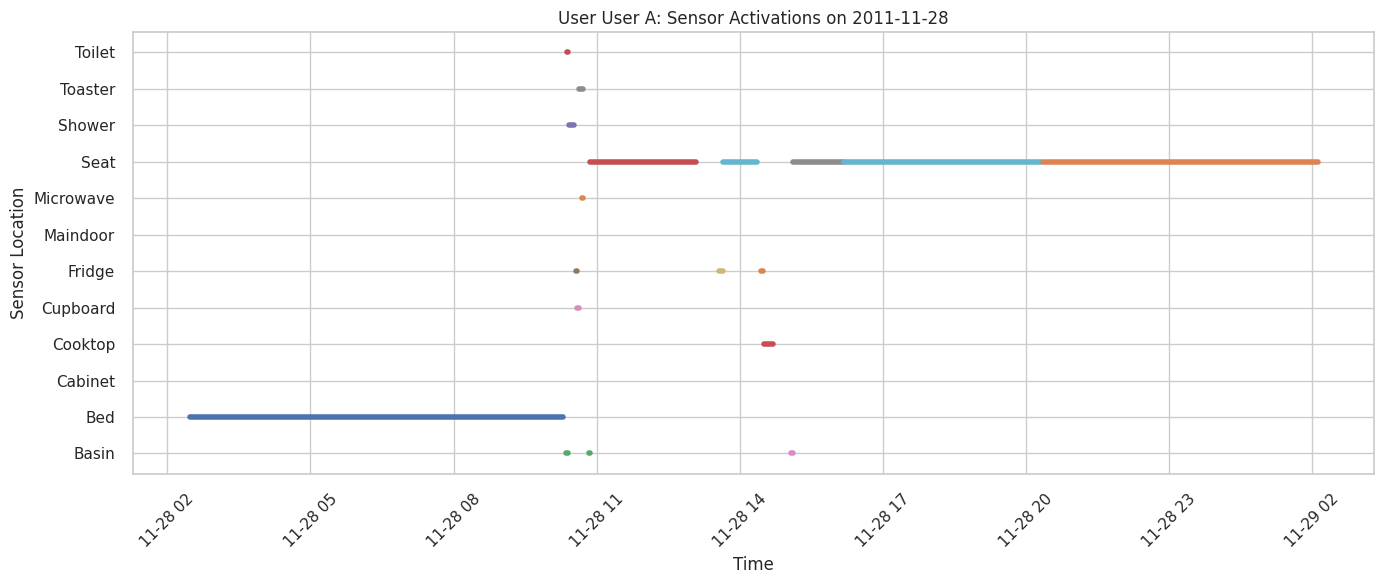

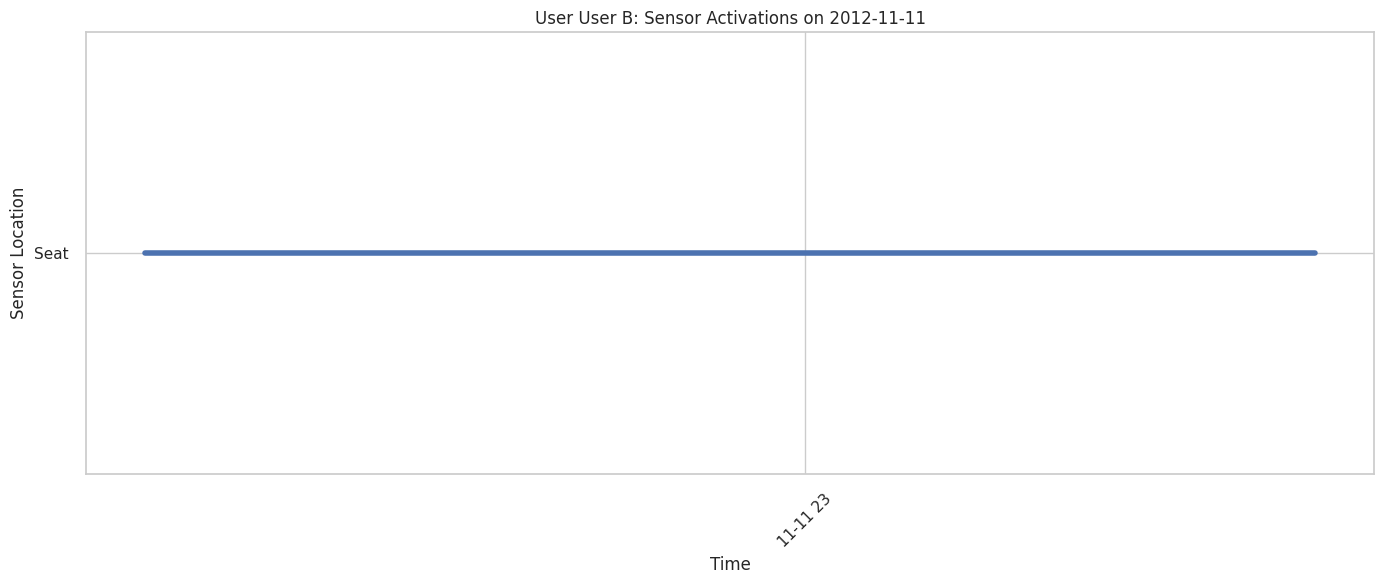

In [7]:
def plot_sensor_activations(sensor_df, user_label, date_to_plot):
    """
    Plots the timeline of sensor activations for a given user on a specific date.

    Parameters:
        sensor_df : pd.DataFrame
            Sensor event logs.
        user_label : str
            Identifier (e.g., "User A").
        date_to_plot : str or datetime
            Specific date to visualize (e.g., '2011-11-28').
    """
    # Ensure datetime format
    sensor_df['start_datetime'] = pd.to_datetime(sensor_df['start_datetime'])
    sensor_df['end_datetime'] = pd.to_datetime(sensor_df['end_datetime'])

    # Filter data for the given date
    df_day = sensor_df[sensor_df['start_datetime'].dt.date == pd.to_datetime(date_to_plot).date()]

    # Order sensor locations for y-axis
    location_order = sorted(df_day['location'].unique())
    location_map = {loc: i for i, loc in enumerate(location_order)}

    # Initialize plot
    fig, ax = plt.subplots(figsize=(14, 6))

    # Draw horizontal bars for each sensor activation
    for _, row in df_day.iterrows():
        y = location_map[row['location']]
        ax.plot([row['start_datetime'], row['end_datetime']], [y, y], lw=4, label=row['location'])

    # Axis formatting
    ax.set_yticks(range(len(location_order)))
    ax.set_yticklabels(location_order)
    ax.set_xlabel("Time")
    ax.set_ylabel("Sensor Location")
    ax.set_title(f"User {user_label}: Sensor Activations on {date_to_plot}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#  Plot first recorded day for both users
first_day_a = sensors_a['start_datetime'].dt.date.min()
plot_sensor_activations(sensors_a, "User A", first_day_a)

first_day_b = sensors_b['start_datetime'].dt.date.min()
plot_sensor_activations(sensors_b, "User B", first_day_b)


# Step 3: Unsupervised Learning: Clustering
In this step, we apply and evaluate multiple unsupervised clustering algorithms to uncover meaningful patterns within the sensor-derived feature data. The primary objective is to identify natural groupings of behavior without using activity labels.

We begin with KMeans clustering, focusing on parameter tuning and performance evaluation using standard clustering metrics such as:
  * Silhouette Score
  * Calinski-Harabasz Index
  * Davies-Bouldin Index

To ensure robustness and enable comparison, we also apply:
  * Agglomerative (Hierarchical) Clustering
  * Gaussian Mixture Model (GMM) Clustering

At the end of this stage, all three clustering approaches are evaluated and compared based on both internal metrics (e.g., silhouette score) and external validation using ground-truth Activity of Daily Living (ADL) labels. The comparison enables us to identify the clustering technique that best captures the underlying structure of daily activity patterns.

#### 1. KMeans Clustering and Elbow Method: ####
To identify the optimal number of clusters (k), KMeans is applied to 2D t-SNE features for k = 2 to 14. The clustering quality is evaluated using:
* WCSS (Inertia): Lower values = tighter clusters
* Silhouette Score: Higher = better-defined clusters
* Calinski-Harabasz Score: Higher = better separation
* Davies-Bouldin Score: Lower = better performance

Each metric is plotted to visualize trends, aiding in:
* Detecting the elbow point in WCSS
* Maximizing silhouette score
* Supporting optimal k via Calinski-Harabasz and Davies-Bouldin

These insights help determine the most meaningful number of clusters for the final KMeans model.


In [8]:
def evaluate_kmeans_clustering(X, k_min=2, k_max=15, random_state=42):
    # Initialize metric lists
    wcss = []                  # Within-cluster sum of squares
    silhouette_scores = []     # Silhouette coefficient
    calinski_scores = []       # Calinski-Harabasz index
    davies_scores = []         # Davies-Bouldin index
    k_range = range(k_min, k_max)

    # Loop over different values of k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X)

        # Compute and store evaluation metrics
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))
        calinski_scores.append(calinski_harabasz_score(X, labels))
        davies_scores.append(davies_bouldin_score(X, labels))

        # Print metrics for each k
        print(f"k = {k}: WCSS = {wcss[-1]:.2f}, Silhouette = {silhouette_scores[-1]:.4f}, "
              f"Calinski-Harabasz = {calinski_scores[-1]:.2f}, Davies-Bouldin = {davies_scores[-1]:.4f}")

    # Plot each metric to visually assess optimal k
    plt.figure(figsize=(16, 5))

    # WCSS plot (Elbow Method)
    plt.subplot(1, 4, 1)
    plt.plot(k_range, wcss, marker='o')
    plt.title("WCSS (Elbow Method)")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("WCSS")

    # Silhouette Score plot
    plt.subplot(1, 4, 2)
    plt.plot(k_range, silhouette_scores, marker='o', color='blue')
    plt.title("Silhouette Score")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Score")

    # Calinski-Harabasz Score plot
    plt.subplot(1, 4, 3)
    plt.plot(k_range, calinski_scores, marker='o', color='green')
    plt.title("Calinski-Harabasz Score")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Score")

    # Davies-Bouldin Score plot
    plt.subplot(1, 4, 4)
    plt.plot(k_range, davies_scores, marker='o', color='red')
    plt.title("Davies-Bouldin Score")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()

    # Return metrics for later analysis or reporting
    return {
        'k_range': list(k_range),
        'wcss': wcss,
        'silhouette': silhouette_scores,
        'calinski': calinski_scores,
        'davies': davies_scores
    }


In [9]:
def preprocess_and_evaluatecluster(features_df, user_label, k_min=2, k_max=15):
    """
    Preprocesses the extracted feature matrix and evaluates KMeans clustering
    across a range of cluster counts using t-SNE for dimensionality reduction.

    Parameters:
        features_df : pd.DataFrame
            Extracted feature matrix for a user.
        user_label : str
            Identifier for the user (e.g., 'User A', 'User B', 'Combined').
        k_min : int
            Minimum number of clusters to evaluate (inclusive).
        k_max : int
            Maximum number of clusters to evaluate (exclusive).

    Returns:
        X_tsne : np.ndarray
            2D representation of data from t-SNE for visualization.
        X_scaled : np.ndarray
            Standardized feature matrix for clustering.
        metrics : dict
            Dictionary containing clustering evaluation scores for each k.
    """
    print(f"\n--- Clustering for User {user_label} ---")

    # Step 1: Removing identifier columns (not needed for clustering)
    df = features_df.drop(columns=['User', 'TimeWindow'], errors='ignore')

    # Step 2: Keeping only numeric features (ignore categorical like True/False dummies)
    df = df.select_dtypes(include=['number'])

    # Step 3: Standardize the features (zero mean, unit variance)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    # Step 4: Applying t-SNE to reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)

    # Step 5: Evaluating KMeans clustering over k range
    metrics = evaluate_kmeans_clustering(X_tsne, k_min=k_min, k_max=k_max)

    return X_tsne, X_scaled, metrics  # Return for downstream clustering/visualization



--- Clustering for User A ---


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


k = 2: WCSS = 8849.95, Silhouette = 0.4022, Calinski-Harabasz = 147.18, Davies-Bouldin = 1.0000
k = 3: WCSS = 4821.09, Silhouette = 0.4702, Calinski-Harabasz = 216.72, Davies-Bouldin = 0.7209
k = 4: WCSS = 3247.04, Silhouette = 0.4756, Calinski-Harabasz = 245.10, Davies-Bouldin = 0.7652
k = 5: WCSS = 2561.98, Silhouette = 0.4524, Calinski-Harabasz = 244.83, Davies-Bouldin = 0.8391
k = 6: WCSS = 1941.37, Silhouette = 0.4858, Calinski-Harabasz = 269.55, Davies-Bouldin = 0.7243
k = 7: WCSS = 1507.03, Silhouette = 0.5143, Calinski-Harabasz = 297.14, Davies-Bouldin = 0.7438
k = 8: WCSS = 1229.23, Silhouette = 0.5214, Calinski-Harabasz = 316.84, Davies-Bouldin = 0.6460
k = 9: WCSS = 1198.70, Silhouette = 0.5080, Calinski-Harabasz = 283.42, Davies-Bouldin = 0.6042
k = 10: WCSS = 1046.45, Silhouette = 0.5059, Calinski-Harabasz = 290.14, Davies-Bouldin = 0.6404
k = 11: WCSS = 840.97, Silhouette = 0.5494, Calinski-Harabasz = 327.84, Davies-Bouldin = 0.6466
k = 12: WCSS = 701.92, Silhouette = 0.5

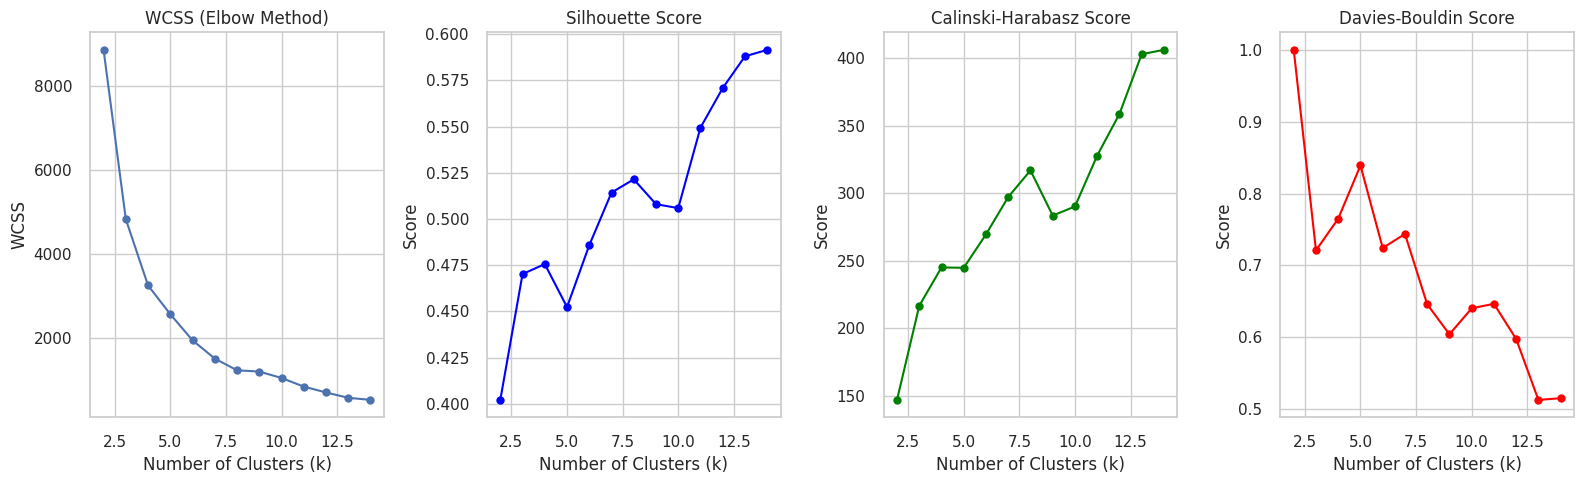


--- Clustering for User B ---


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


k = 2: WCSS = 206417.95, Silhouette = 0.3966, Calinski-Harabasz = 461.87, Davies-Bouldin = 1.0823
k = 3: WCSS = 130046.52, Silhouette = 0.3921, Calinski-Harabasz = 558.92, Davies-Bouldin = 0.8972
k = 4: WCSS = 100216.55, Silhouette = 0.4159, Calinski-Harabasz = 547.87, Davies-Bouldin = 0.8300
k = 5: WCSS = 62886.21, Silhouette = 0.4862, Calinski-Harabasz = 751.03, Davies-Bouldin = 0.7213
k = 6: WCSS = 45995.22, Silhouette = 0.5099, Calinski-Harabasz = 868.25, Davies-Bouldin = 0.6326
k = 7: WCSS = 35990.78, Silhouette = 0.5188, Calinski-Harabasz = 953.58, Davies-Bouldin = 0.6632
k = 8: WCSS = 26122.76, Silhouette = 0.5403, Calinski-Harabasz = 1159.48, Davies-Bouldin = 0.6445
k = 9: WCSS = 22335.02, Silhouette = 0.5354, Calinski-Harabasz = 1198.58, Davies-Bouldin = 0.6417
k = 10: WCSS = 17843.41, Silhouette = 0.5660, Calinski-Harabasz = 1349.72, Davies-Bouldin = 0.5620
k = 11: WCSS = 14589.39, Silhouette = 0.5808, Calinski-Harabasz = 1498.41, Davies-Bouldin = 0.5849
k = 12: WCSS = 12943.

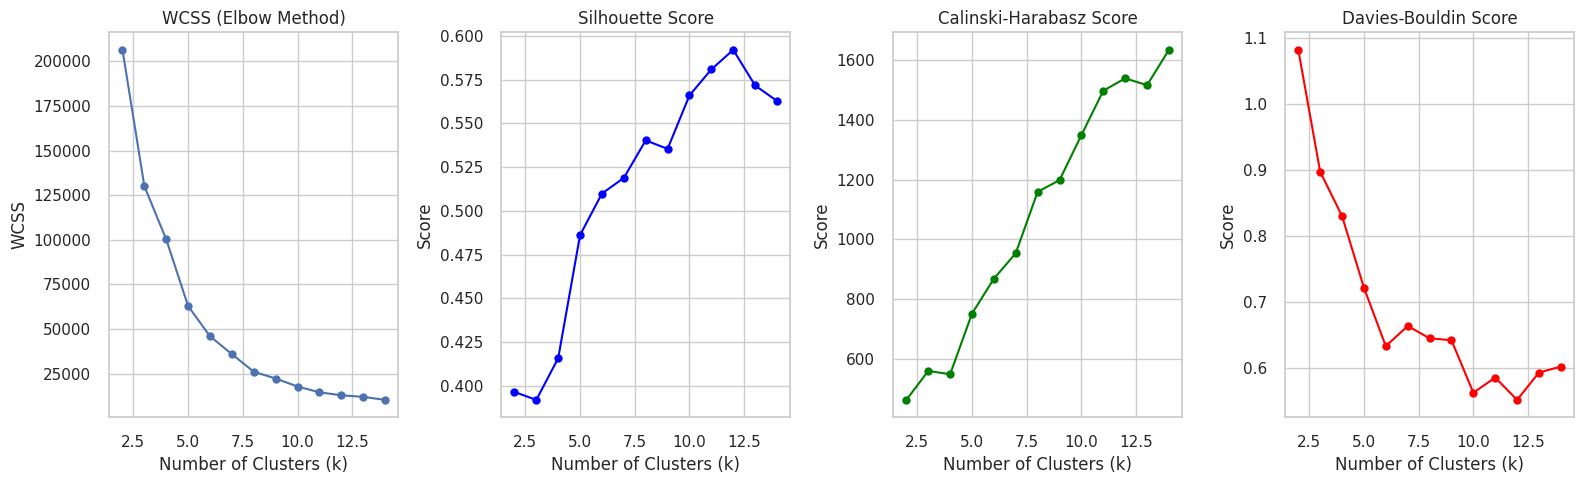

In [10]:
X_tsne_a, X_scaled_a, metrics_a = preprocess_and_evaluatecluster(features_a, user_label='A')
X_tsne_b, X_scaled_b, metrics_b = preprocess_and_evaluatecluster(features_b, user_label='B')


In [11]:
def run_kmeans_clustering(X_scaled, X_tsne, k, user_label, true_labels=None, visualize=True):
    """
    Runs KMeans clustering on scaled features, evaluates it (if labels provided),
    and optionally visualizes the result in 2D t-SNE space.

    Parameters:
        X_scaled : np.ndarray
            Standardized feature array (used for clustering).
        X_tsne : np.ndarray
            2D t-SNE transformed array (used for plotting).
        k : int
            Number of clusters to use in KMeans.
        user_label : str
            User identifier (e.g., 'User A', 'Combined').
        true_labels : array-like, optional
            Ground-truth labels (ADL activities) for evaluation.
        visualize : bool
            If True, shows t-SNE scatter plot colored by cluster assignment.

    Returns:
        cluster_labels : np.ndarray
            Predicted cluster assignments for each sample.
    """

    print(f"\n Running KMeans for {user_label} with k = {k}...")

    # Step 1: Apply KMeans clustering to the standardized feature set
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Step 2: Evaluating clustering performance if true labels are provided
    if true_labels is not None:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        nmi = normalized_mutual_info_score(true_labels, cluster_labels)
        silhouette = silhouette_score(X_scaled, cluster_labels)

        print(f" Adjusted Rand Index (ARI): {ari:.4f}")
        print(f" Normalized Mutual Info (NMI): {nmi:.4f}")
        print(f" Silhouette Score: {silhouette:.4f}")

    # Step 3: Visualizing clusters in 2D t-SNE space if enabled
    if visualize:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            X_tsne[:, 0], X_tsne[:, 1],
            c=cluster_labels, cmap='tab10', s=60, alpha=0.8
        )
        plt.colorbar(scatter, label='Cluster Label')
        plt.title(f"{user_label} - KMeans Clustering (k = {k})")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return cluster_labels



 Running KMeans for User A with k = 8...


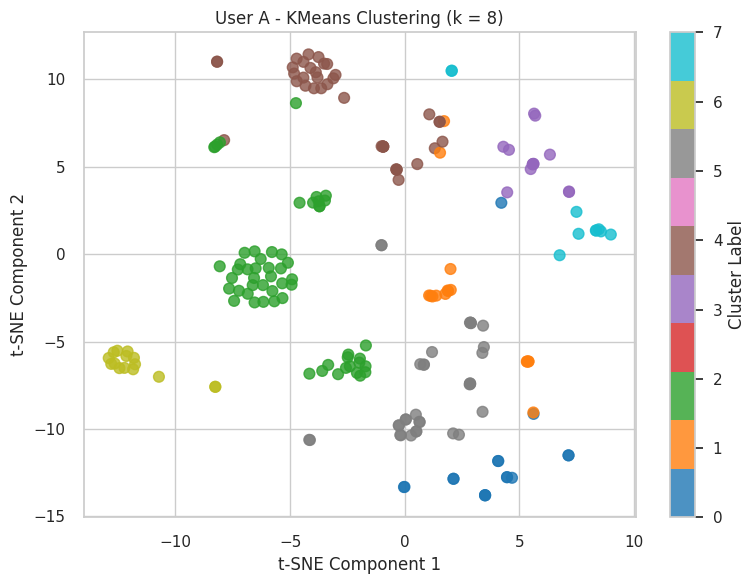


 Running KMeans for User B with k = 8...


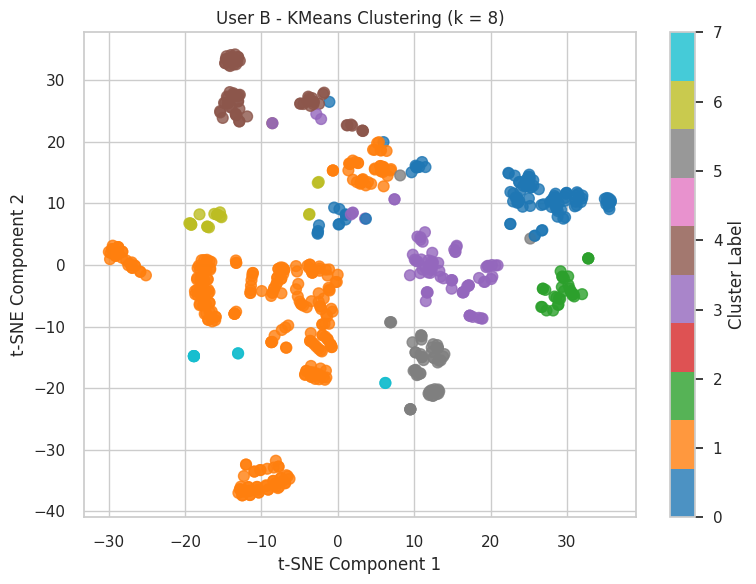

In [12]:
clusters_a = run_kmeans_clustering(X_scaled_a, X_tsne_a, k=8, user_label='User A')

clusters_b = run_kmeans_clustering(X_scaled_b, X_tsne_b, k=8, user_label='User B')


#### Combining user dataset and applying KMeans

Combined Sensor Events: 2743

 Extracting features for A+B...


<ipython-input-5-15344b8aad9a>:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sensor_df['TimeWindow'] = sensor_df[time_column].dt.floor(f'{window_minutes}T')


-> Features extracted for A+B: 860 windows, 91 features
Extracted Feature Matrix Shape: (860, 91)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


k = 2: WCSS = 307142.53, Silhouette = 0.4129, Calinski-Harabasz = 706.48, Davies-Bouldin = 0.9913
k = 3: WCSS = 211634.98, Silhouette = 0.4056, Calinski-Harabasz = 705.42, Davies-Bouldin = 0.9083
k = 4: WCSS = 147592.92, Silhouette = 0.4051, Calinski-Harabasz = 797.36, Davies-Bouldin = 0.8853
k = 5: WCSS = 126167.64, Silhouette = 0.4174, Calinski-Harabasz = 735.08, Davies-Bouldin = 0.8173
k = 6: WCSS = 86406.67, Silhouette = 0.4625, Calinski-Harabasz = 936.23, Davies-Bouldin = 0.7347
k = 7: WCSS = 79047.79, Silhouette = 0.4503, Calinski-Harabasz = 865.06, Davies-Bouldin = 0.7049
k = 8: WCSS = 53357.60, Silhouette = 0.4864, Calinski-Harabasz = 1155.80, Davies-Bouldin = 0.6521
k = 9: WCSS = 45241.13, Silhouette = 0.4916, Calinski-Harabasz = 1210.44, Davies-Bouldin = 0.6725
k = 10: WCSS = 38314.07, Silhouette = 0.5160, Calinski-Harabasz = 1286.06, Davies-Bouldin = 0.6886
k = 11: WCSS = 35436.95, Silhouette = 0.5301, Calinski-Harabasz = 1256.96, Davies-Bouldin = 0.6616
k = 12: WCSS = 31324

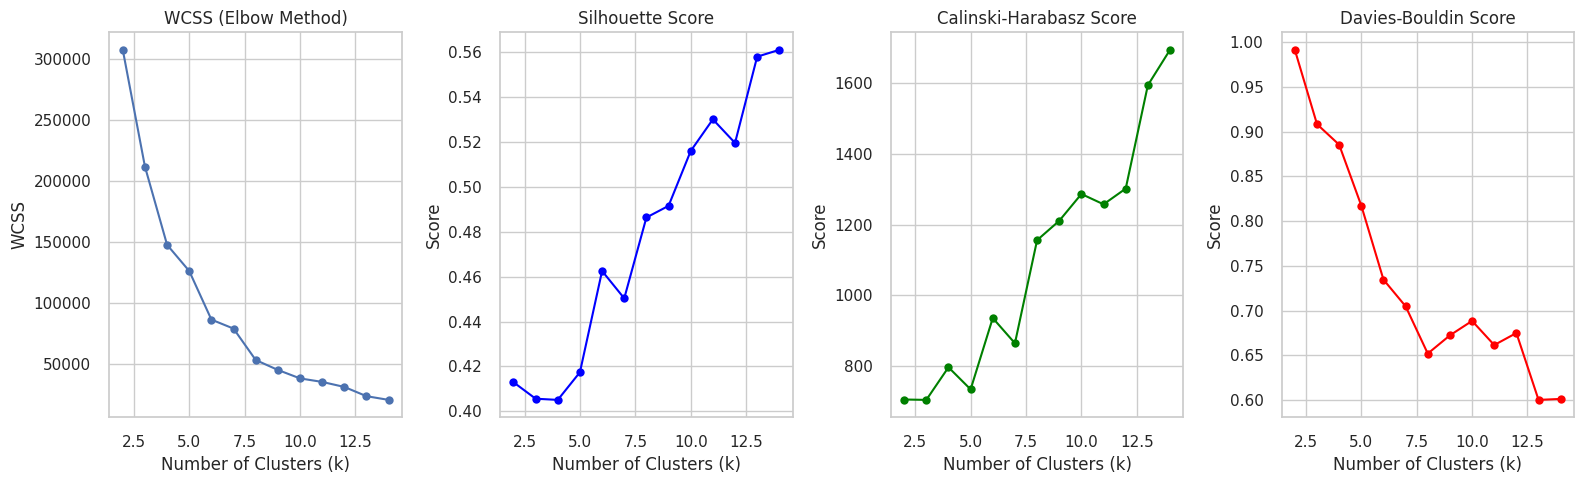

In [13]:
# ---------------------------
# STEP 1: Combine Sensor Data
# Merging sensor events from both users into one dataset
sensors_ab = pd.concat([sensors_a, sensors_b], ignore_index=True)
print(f"Combined Sensor Events: {len(sensors_ab)}")

# ---------------------------
# STEP 2: Extract Features for Combined Data
# Generate time-windowed behavioral features (event counts, durations, transitions, etc.)
features_ab = extract_transition_features(sensors_ab, user_label='A+B')  # Treat as one combined dataset
print(f"Extracted Feature Matrix Shape: {features_ab.shape}")

# ---------------------------
# STEP 3: Prepare for Clustering
# Saving original metadata for later reference (e.g., labeling clusters)
users_ab = features_ab['User'].values
time_windows_ab = features_ab['TimeWindow'].values

# Keepong only numeric features (drop user/time info and non-numeric columns)
features_numeric_ab = features_ab.drop(columns=['User', 'TimeWindow'], errors='ignore')
features_numeric_ab = features_numeric_ab.select_dtypes(include=['number'])

# Standardize feature values (zero mean, unit variance)
scaler_ab = StandardScaler()
X_scaled_ab = scaler_ab.fit_transform(features_numeric_ab)

# Reduce dimensionality for visualization using t-SNE (2D space)
tsne_ab = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_ab = tsne_ab.fit_transform(X_scaled_ab)

# ---------------------------
# STEP 4: Evaluate Optimal K
# Run KMeans over a range of k values and compute clustering quality metrics
metrics_ab = evaluate_kmeans_clustering(X_tsne_ab, k_min=2, k_max=15)



 Running KMeans for Combined Users A+B with k = 10...


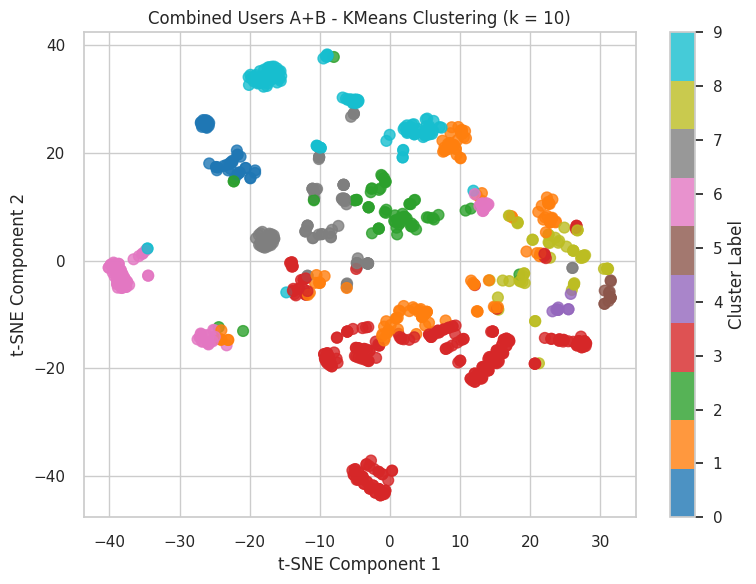


 Cluster Summary (event count & entropy):
         event_count  location_entropy
cluster                               
0           2.727273          0.573936
1           6.219512          0.403690
2           5.692308          0.833980
3           2.210526          0.101810
4           3.222222          0.995422
5           4.692308          1.469152
6           2.089744          0.358475
7           2.184783          0.556857
8           3.964286          0.672449
9           1.964912          0.460960


In [14]:
# ---------------------------
# STEP 5: Apply Final KMeans with Chosen K
# Applying KMeans using the optimal number of clusters ( from elbow/silhouette analysis)
k_ab = 10  # as per evaluations performed in previous steps
clusters_ab = run_kmeans_clustering(
    X_scaled_ab,
    X_tsne_ab,
    k=k_ab,          # final no. of clusters
    user_label="Combined Users A+B"
)

# ---------------------------
# STEP 6: Save Cluster Assignments
# Adding cluster labels and original metadata back to the feature matrix for future analysis
features_ab['cluster'] = clusters_ab
features_ab['TimeWindow'] = time_windows_ab
features_ab['User'] = users_ab

# ---------------------------
# STEP 7: Cluster Profiling
# Generate summary statistics for each cluster (like event count and location entropy)
cluster_summary = features_ab.groupby('cluster')[['event_count', 'location_entropy']].mean()

print("\n Cluster Summary (event count & entropy):")
print(cluster_summary)


This step identifies the most influential features contributing to cluster separation using a PCA-based interpretation of KMeans. After reducing the dimensionality of the standardized features with PCA, KMeans is applied to the transformed data. The resulting cluster centers are then inverse-transformed back to the original feature space, allowing the computation of feature-wise variance across clusters. Features with higher variance are considered more important, as they exhibit stronger influence in distinguishing between clusters. The top 15 features are visualized and listed to provide interpretable insights into the clustering structure.

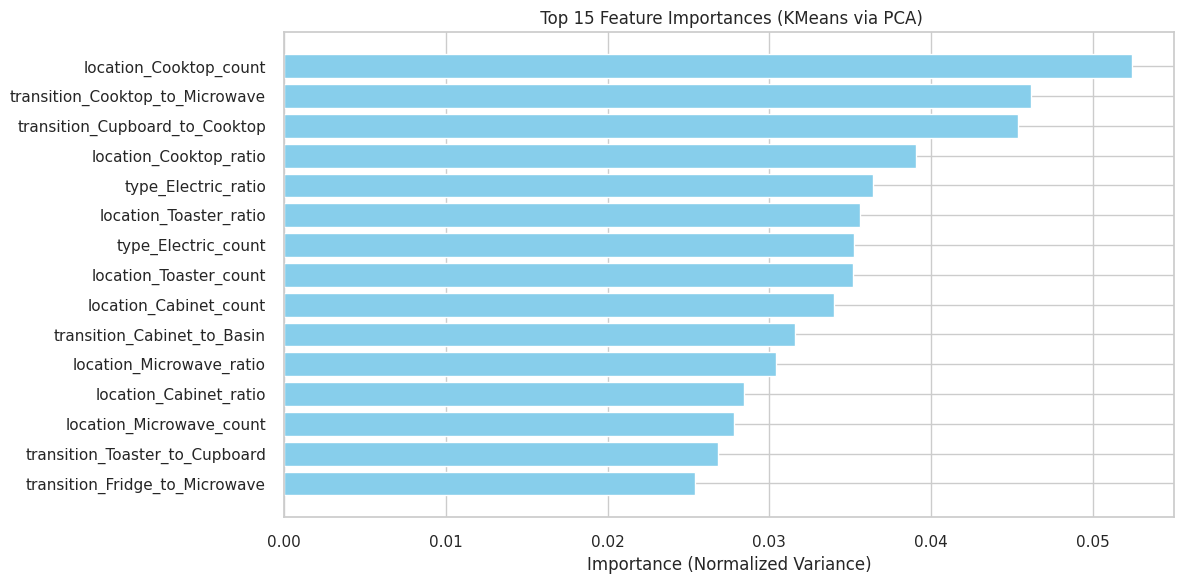


Top 15 Important Features Based on Cluster Separation:
location_Cooktop_count         : 0.0524
transition_Cooktop_to_Microwave : 0.0462
transition_Cupboard_to_Cooktop : 0.0454
location_Cooktop_ratio         : 0.0391
type_Electric_ratio            : 0.0364
location_Toaster_ratio         : 0.0356
type_Electric_count            : 0.0353
location_Toaster_count         : 0.0352
location_Cabinet_count         : 0.0340
transition_Cabinet_to_Basin    : 0.0316
location_Microwave_ratio       : 0.0304
location_Cabinet_ratio         : 0.0284
location_Microwave_count       : 0.0278
transition_Toaster_to_Cupboard : 0.0268
transition_Fridge_to_Microwave : 0.0254


In [15]:
# ----------------------------------------
# STEP 1: Apply PCA on Scaled Feature Data
# Reduces dimensionality to retain top components (helps in interpretation + efficiency)
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_scaled_ab)

# ----------------------------------------
# STEP 2: Fit KMeans on PCA-transformed Features
# KMeans clustering applied on reduced dimensions for stable center extraction
kmeans_pca = KMeans(n_clusters=k_ab, random_state=42)
kmeans_pca.fit(X_pca)

# ----------------------------------------
# STEP 3: Project Cluster Centers Back to Original Feature Space
# Inverse transforms centers to match the original scaled features for interpretability
centers_original = pca.inverse_transform(kmeans_pca.cluster_centers_)

# ----------------------------------------
# STEP 4: Compute Feature Importance Based on Cluster Center Variance
def get_feature_importance_kmeans(features_scaled, cluster_centers, feature_names):
    """
    Calculates feature importance by computing normalized variance of cluster centers
    across each feature dimension (higher variance = more influential feature).
    """
    feature_variance = np.var(cluster_centers, axis=0)
    feature_importance = feature_variance / np.sum(feature_variance)
    importance_pairs = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)
    return importance_pairs

# Get feature importances using the variance method
feature_importance = get_feature_importance_kmeans(
    features_scaled=X_scaled_ab,
    cluster_centers=centers_original,
    feature_names=features_numeric_ab.columns
)

# ----------------------------------------
# STEP 5: Plot Top 15 Important Features
top_15 = feature_importance[:15]

plt.figure(figsize=(12, 6))
plt.barh([f for f, _ in reversed(top_15)], [imp for _, imp in reversed(top_15)], color='skyblue')
plt.title(' Top 15 Feature Importances (KMeans via PCA)')
plt.xlabel('Importance (Normalized Variance)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------
# STEP 6: Print Top Features with Scores
print("\nTop 15 Important Features Based on Cluster Separation:")
for feature, score in top_15:
    print(f"{feature:<30} : {score:.4f}")


#### 2. Agglomerative Clustering:
* Agglomerative Clustering is a hierarchical clustering algorithm that builds a tree-like structure (dendrogram) by iteratively merging clusters based on a linkage criterion. The parameters that influence this method include the number of clusters (n_clusters) and the linkage method (ward, average, or complete).


In [16]:
from sklearn.cluster import AgglomerativeClustering

def run_agglomerative_clustering(X_scaled, X_tsne, k, user_label="Combined", visualize=True):
    """
    Parameters:
        X_scaled : np.ndarray
            Standardized feature array.
        X_tsne : np.ndarray
            2D t-SNE array for visualization.
        k : int
            Number of clusters.
        user_label : str
            Identifier for the dataset.
        visualize : bool
            Whether to plot t-SNE visualizations.

    Returns:
        cluster_labels : np.ndarray
            Cluster assignments from Agglomerative Clustering.
    """
    print(f"\n Running Agglomerative Clustering for {user_label} with k = {k}...")
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = agg.fit_predict(X_scaled)

    if visualize:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10', s=60, alpha=0.8)
        plt.colorbar(scatter, label='Cluster Label')
        plt.title(f"{user_label} - Agglomerative Clustering (k = {k})")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return cluster_labels



 Running Agglomerative Clustering for Combined Users A+B with k = 10...


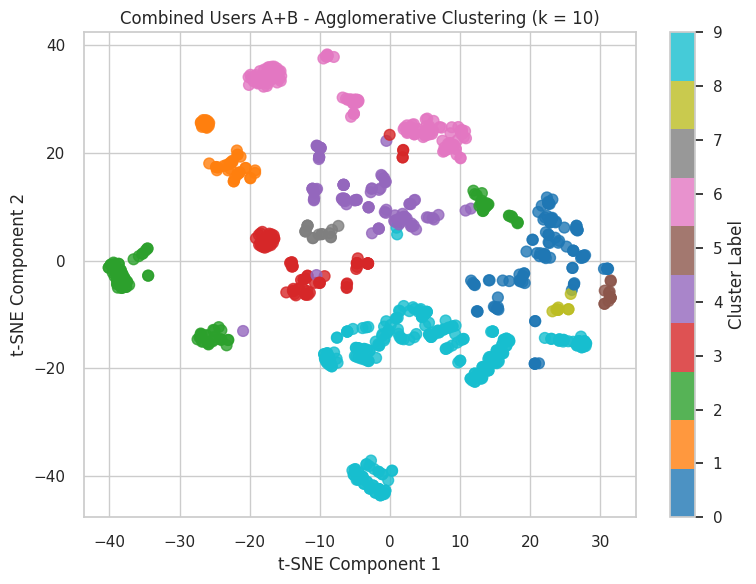

In [17]:
k_ab = 10  # Optimal number of clusters determined previously

# Agglomerative Clustering
clusters_agg = run_agglomerative_clustering(X_scaled_ab, X_tsne_ab, k=k_ab, user_label="Combined Users A+B")
features_ab['cluster_agg'] = clusters_agg

#### 3. GMM Clustering
Gaussian Mixture Model (GMM) clustering is a **probabilistic approach** to clustering that assumes data is generated from a mixture of several **Gaussian distributions**. Unlike KMeans, which assigns each point to a single cluster, GMM estimates the **probability** of each point belonging to each cluster, allowing for **soft assignments**. This makes GMM more flexible, especially for clusters with **elliptical shapes or varying densities**. The model uses the **Expectation-Maximization (EM)** algorithm to iteratively refine cluster parameters (means, covariances, and weights), aiming to maximize the likelihood of the observed data.

In [18]:
from sklearn.mixture import GaussianMixture

def run_gmm_clustering(X_scaled, X_tsne, k, user_label="Combined", visualize=True):
    """
    Parameters:
        X_scaled : np.ndarray
            Standardized feature array.
        X_tsne : np.ndarray
            2D t-SNE array for visualization.
        k : int
            Number of clusters.
        user_label : str
            Identifier for the dataset.
        visualize : bool
            Whether to plot t-SNE visualizations.

    Returns:
        cluster_labels : np.ndarray
            Cluster assignments from GMM.
    """
    print(f"\n Running GMM Clustering for {user_label} with k = {k}...")
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    cluster_labels = gmm.predict(X_scaled)

    if visualize:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10', s=60, alpha=0.8)
        plt.colorbar(scatter, label='Cluster Label')
        plt.title(f"{user_label} - GMM Clustering (k = {k})")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return cluster_labels



 Running GMM Clustering for Combined Users A+B with k = 10...


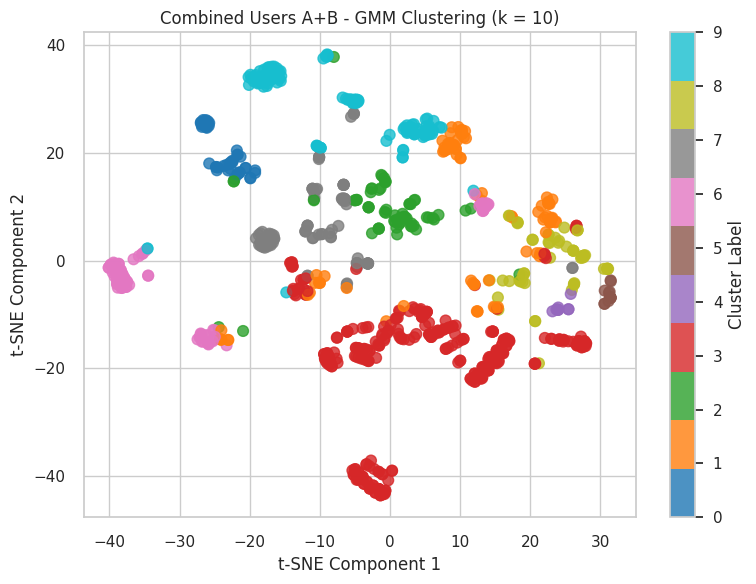

In [19]:
k_ab = 10  # Optimal number of clusters determined previously

# GMM Clustering
clusters_gmm = run_gmm_clustering(X_scaled_ab, X_tsne_ab, k=k_ab, user_label="Combined Users A+B")
features_ab['cluster_gmm'] = clusters_gmm

#Step 4: External Validation using ADL Labels and Clustering Evaluation #
This step focuses on evaluating the performance of the two clustering algorithms (KMeans and Agglomerative Clustering) by comparing their results against the True Labels derived from Activity of Daily Living (ADL) data. The clustering results are validated using several evaluation metrics like Adjusted Rand Index (ARI), Normalized Mutual Information (NMI), and Homogeneity, Completeness, and V-Measure.

In this step, the ADL (Activity of Daily Living) label data is prepared and mapped to the same time windows used for feature extraction. This allows us to compare the clusters formed by unsupervised algorithms (e.g., KMeans, Agglomerative) to the ground truth activities.

- **add_time_windows_to_adl**(): Expands ADL activity intervals into 10-minute windows to match the feature granularity.
- **map_adl_to_features**(): Aligns each feature time window with the most frequent ADL label occurring during that window.
- **evaluate_cluster_vs_adl**(): Compares clustering results to true ADL labels using metrics like:
  - **Adjusted Rand Index (ARI)**
  - **Normalized Mutual Information (NMI)**
  - **Homogeneity**
  - **Completeness**
  - **V-Measure**
  It also generates a confusion matrix for deeper interpretation.

Together, these functions enable **external validation of clustering quality** by checking how well clusters align with actual daily activities.

In [20]:
# ----------------------------------------------
# Convert ADL Activities to Time Window Format
def add_time_windows_to_adl(adl_df, window_minutes=10):
    """
    Converts start-end time intervals of ADL activities into discrete time windows.
    This allows aligning activity labels with sensor feature windows for evaluation.
    """

    # Ensure datetime format for start and end times
    adl_df['start_datetime'] = pd.to_datetime(adl_df['start_datetime'])
    adl_df['end_datetime'] = pd.to_datetime(adl_df['end_datetime'])

    adl_expanded = []

    # Loop through each ADL activity
    for _, row in adl_df.iterrows():
        current = row['start_datetime']

        # Slide through time in steps of window_minutes until end of the activity
        while current < row['end_datetime']:
            window_start = current.floor(f'{window_minutes}T')  # Align to the nearest window
            adl_expanded.append({
                'TimeWindow': window_start,
                'activity': row['activity']
            })
            current += pd.Timedelta(minutes=window_minutes)

    # Returning as a DataFrame with TimeWindow and activity labels
    return pd.DataFrame(adl_expanded)


In [21]:
# Map ADLs to Feature Rows
def map_adl_to_features(features_df, adl_mapped_df):
    # Count majority activity per TimeWindow
    activity_per_window = adl_mapped_df.groupby('TimeWindow')['activity'] \
                                       .agg(lambda x: x.mode()[0] if not x.empty else 'None') \
                                       .reset_index()

    # Merge with feature windows
    features_labeled = features_df.merge(activity_per_window, on='TimeWindow', how='left')
    return features_labeled


In [22]:
# Evaluateing Clustering Against ADLs
def evaluate_cluster_vs_adl(features_labeled_df, cluster_col='cluster', adl_col='activity'):
    valid_rows = features_labeled_df[
        (features_labeled_df[adl_col].notna()) &
        (features_labeled_df[adl_col] != 'None')
    ]

    y_true = valid_rows[adl_col]
    y_pred = valid_rows[cluster_col]

    # Convert ADLs to numeric labels
    label_encoder = LabelEncoder()
    y_true_encoded = label_encoder.fit_transform(y_true)

    # Ensure y_pred is numpy array
    y_pred = np.array(y_pred)

    # Evaluate
    ari = adjusted_rand_score(y_true_encoded, y_pred)
    nmi = normalized_mutual_info_score(y_true_encoded, y_pred)
    homogeneity = homogeneity_score(y_true_encoded, y_pred)
    completeness = completeness_score(y_true_encoded, y_pred)
    v_measure = v_measure_score(y_true_encoded, y_pred)

    print(f"Adjusted Rand Index (ARI):      {ari:.4f}")
    print(f"Normalized Mutual Info (NMI):   {nmi:.4f}")
    print(f"Homogeneity Score:              {homogeneity:.4f}")
    print(f"Completeness Score:             {completeness:.4f}")
    print(f"V-Measure:                      {v_measure:.4f}")

    metrics_dict = {
        'ARI': ari,
        'NMI': nmi,
        'Homogeneity': homogeneity,
        'Completeness': completeness,
        'V-Measure': v_measure
    }

    conf = confusion_matrix(y_true_encoded, y_pred)

    # Optional: decode label names for interpretation
    labels = label_encoder.classes_
    return conf, y_true_encoded, y_pred, labels, metrics_dict



In [23]:
adl_a = data_loader(base_path + 'OrdonezA_ADLs.txt', 'adl')
adl_b = data_loader(base_path + 'OrdonezB_ADLs.txt', 'adl')

# Add user labels
adl_a['User'] = 'A'
adl_b['User'] = 'B'

# Combine both ADLs
adl_ab = pd.concat([adl_a, adl_b], ignore_index=True)

# Map to time windows (same method as before)
adl_ab_mapped = add_time_windows_to_adl(adl_ab)
adl_ab_mapped.head()


<ipython-input-20-04730389b2b9>:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  window_start = current.floor(f'{window_minutes}T')  # Align to the nearest window


,TimeWindow,activity
0,2011-11-28 02:20:00,Sleeping
1,2011-11-28 02:30:00,Sleeping
2,2011-11-28 02:40:00,Sleeping
3,2011-11-28 02:50:00,Sleeping
4,2011-11-28 03:00:00,Sleeping


In [24]:
# For user A using KMeans
# Step 1: Attach cluster labels to features
features_a['cluster'] = clusters_a

# Step 2: Map ADL labels to same TimeWindow format
adl_a_mapped = add_time_windows_to_adl(adl_a)

# Step 3: Merge ADL activity into feature rows
features_a_eval = map_adl_to_features(features_a, adl_a_mapped)

# Step 4: Evaluate
conf_matrix_a, y_true_a, y_pred_a, adl_labels_a, metrics_a_kmeans = evaluate_cluster_vs_adl(features_a_eval)


<ipython-input-20-04730389b2b9>:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  window_start = current.floor(f'{window_minutes}T')  # Align to the nearest window


Adjusted Rand Index (ARI):      0.4111
Normalized Mutual Info (NMI):   0.5676
Homogeneity Score:              0.5719
Completeness Score:             0.5633
V-Measure:                      0.5676


In [25]:
# For user B using KMeans
features_b['cluster'] = clusters_b
adl_b_mapped = add_time_windows_to_adl(adl_b)
features_b_eval = map_adl_to_features(features_b, adl_b_mapped)
conf_matrix_b, y_true_b, y_pred_b, adl_labels_b, metrics_b_kmeans = evaluate_cluster_vs_adl(features_b_eval)


<ipython-input-20-04730389b2b9>:21: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  window_start = current.floor(f'{window_minutes}T')  # Align to the nearest window


Adjusted Rand Index (ARI):      0.2800
Normalized Mutual Info (NMI):   0.4388
Homogeneity Score:              0.4235
Completeness Score:             0.4553
V-Measure:                      0.4388


In [26]:
# Users A and B combined using KMeans clustering
features_ab_eval = map_adl_to_features(features_ab.copy(), adl_ab_mapped)
conf_matrix_ab, y_true_ab, y_pred_ab, adl_labels_ab, metrics_ab_kmeans = evaluate_cluster_vs_adl(features_ab_eval)


Adjusted Rand Index (ARI):      0.2280
Normalized Mutual Info (NMI):   0.3757
Homogeneity Score:              0.3901
Completeness Score:             0.3623
V-Measure:                      0.3757


In [27]:

def plot_confusion_matrix_labeled(conf_matrix, labels, title="Confusion Matrix", figsize=(10, 6)):
    """
    Plot a labeled confusion matrix heatmap.

    Parameters:
    - conf_matrix: The confusion matrix (2D array)
    - labels: List of string labels for ADL classes
    - title: Title of the plot
    - figsize: Size of the plot
    """
    plt.figure(figsize=figsize)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=range(conf_matrix.shape[1]),
                yticklabels=labels)
    plt.xlabel("Cluster ID")
    plt.ylabel("True Activity (ADL)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


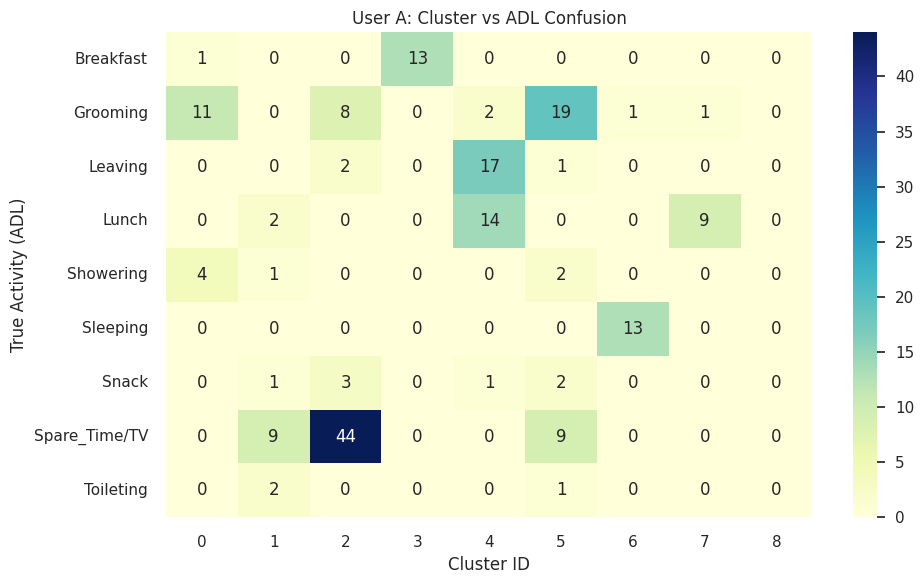

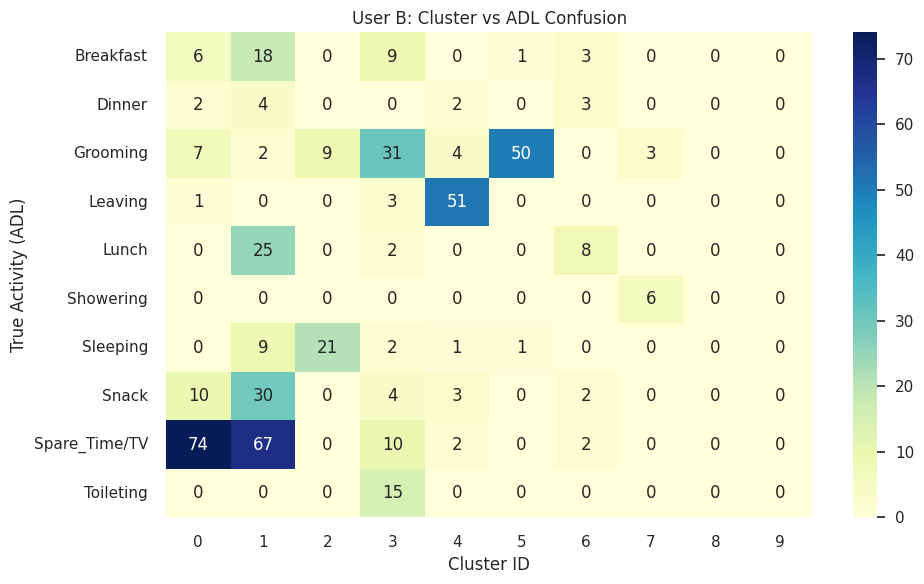

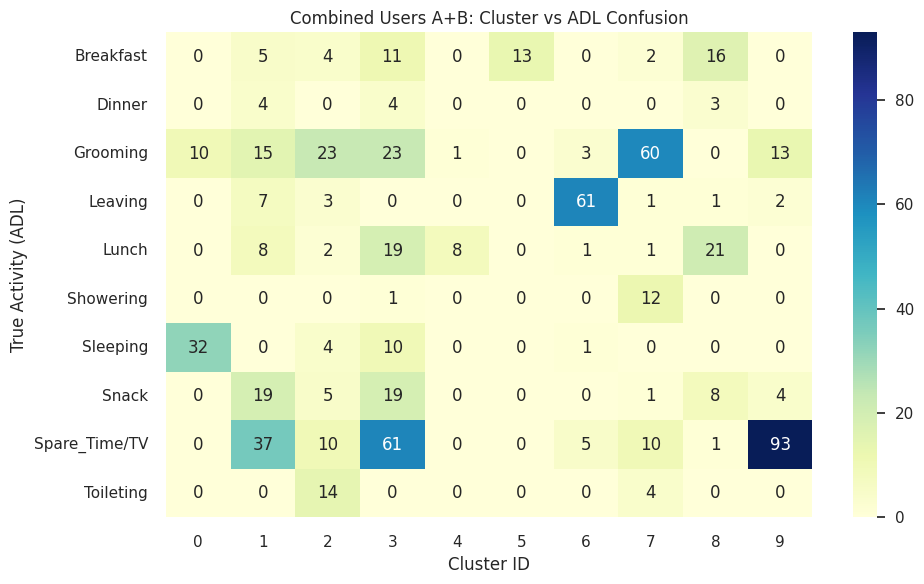

In [28]:
# For User A
plot_confusion_matrix_labeled(conf_matrix_a, adl_labels_a, title="User A: Cluster vs ADL Confusion")

# For User B
plot_confusion_matrix_labeled(conf_matrix_b, adl_labels_b, title="User B: Cluster vs ADL Confusion")

# For Combined A+B
plot_confusion_matrix_labeled(conf_matrix_ab, adl_labels_ab, title="Combined Users A+B: Cluster vs ADL Confusion")


KMeans Evaluation Metrics:
Adjusted Rand Index (ARI):      0.2280
Normalized Mutual Info (NMI):   0.3757
Homogeneity Score:              0.3901
Completeness Score:             0.3623
V-Measure:                      0.3757


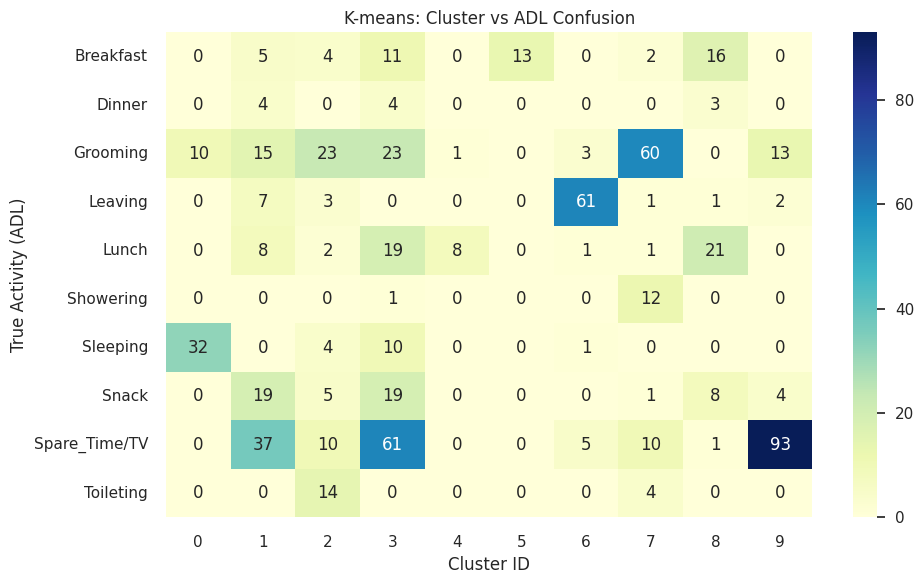

Agglomerative Clustering Evaluation Metrics:
Adjusted Rand Index (ARI):      0.3312
Normalized Mutual Info (NMI):   0.4636
Homogeneity Score:              0.4774
Completeness Score:             0.4505
V-Measure:                      0.4636


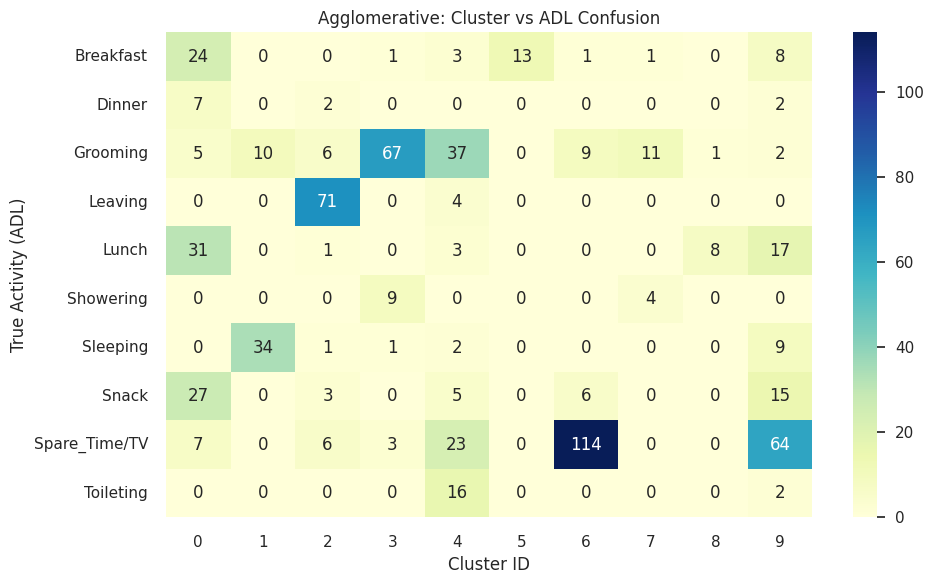

GMM Clustering Evaluation Metrics:
Adjusted Rand Index (ARI):      0.2288
Normalized Mutual Info (NMI):   0.3767
Homogeneity Score:              0.3907
Completeness Score:             0.3637
V-Measure:                      0.3767


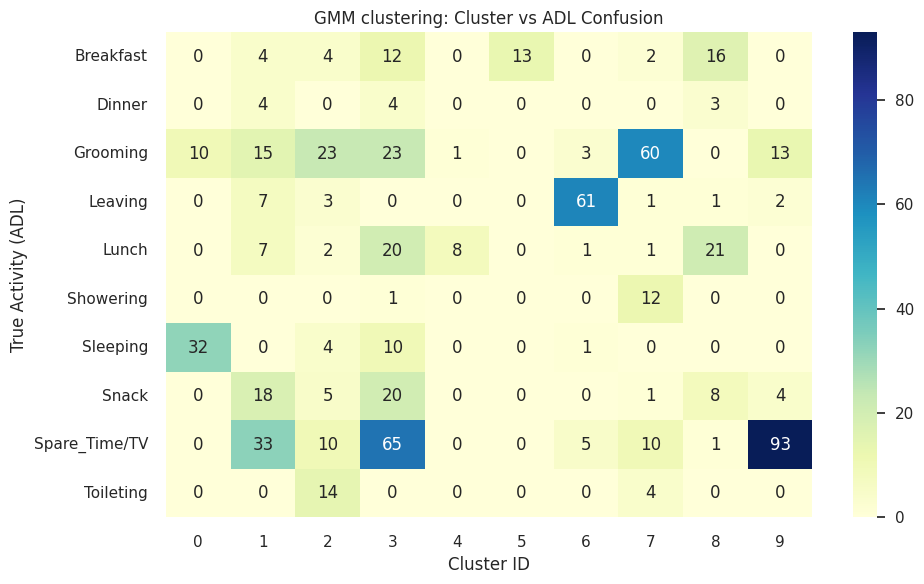

In [29]:
# This section evaluates how well the clusters generated by three unsupervised algorithms
#  (KMeans, Agglomerative, and GMM) align with the true Activity of Daily Living (ADL) labels.
#  It uses five clustering performance metrics and visualizes the results with confusion matrices

# 1- KMeans Evaluation
print("KMeans Evaluation Metrics:")
conf_kmeans, y_true_kmeans, y_pred_kmeans, labels_kmeans, metrics_kmeans = evaluate_cluster_vs_adl(features_ab_eval, cluster_col='cluster')
plot_confusion_matrix_labeled(conf_kmeans, adl_labels_ab, title="K-means: Cluster vs ADL Confusion")


# 2 - Agglomerative Clustering Evaluation
print("Agglomerative Clustering Evaluation Metrics:")
conf_agg, y_true_agg, y_pred_agg, labels_agg, metrics_agg = evaluate_cluster_vs_adl(features_ab_eval, cluster_col='cluster_agg')
plot_confusion_matrix_labeled(conf_agg, adl_labels_ab, title="Agglomerative: Cluster vs ADL Confusion")


# 3 - GMM Clustering Evaluation
print("GMM Clustering Evaluation Metrics:")
conf_gmm, y_true_gmm, y_pred_gmm, labels_gmm, metrics_gmm = evaluate_cluster_vs_adl(features_ab_eval, cluster_col='cluster_gmm')
plot_confusion_matrix_labeled(conf_gmm, adl_labels_ab, title="GMM clustering: Cluster vs ADL Confusion")




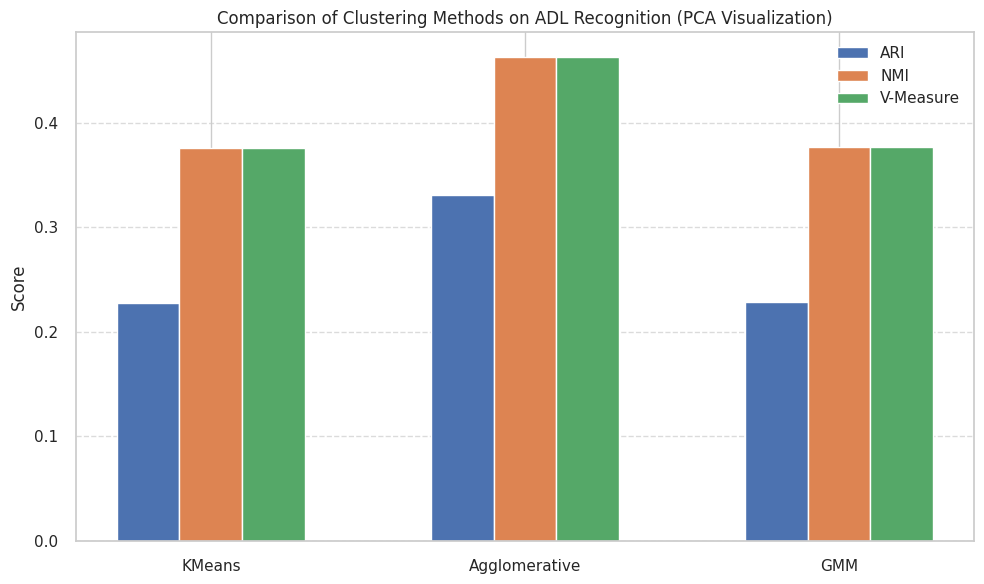

In [30]:
# This final section compares the performance of three clustering methods—KMeans, Agglomerative, and GMM
# on the ADL recognition task using external validation metrics. It visualizes the Adjusted Rand Index (ARI),
# Normalized Mutual Information (NMI), and V-Measure for each method, helping to assess which clustering approach best aligns with true activity labels.

# -----------------------------------------------
# Cluster Evaluation: Compare Clustering Metrics

# Defineing clustering methods and collect their evaluation scores
methods = ['KMeans', 'Agglomerative', 'GMM']
ari_scores = [metrics_kmeans['ARI'], metrics_agg['ARI'], metrics_gmm['ARI']]
nmi_scores = [metrics_kmeans['NMI'], metrics_agg['NMI'], metrics_gmm['NMI']]
v_measure_scores = [metrics_kmeans['V-Measure'], metrics_agg['V-Measure'], metrics_gmm['V-Measure']]

# X-axis positioning for grouped bar plot
x = range(len(methods))
width = 0.2

plt.figure(figsize=(10, 6))

# Plot each metric as grouped bars
plt.bar([p - width for p in x], ari_scores, width=width, label='ARI')
plt.bar(x, nmi_scores, width=width, label='NMI')
plt.bar([p + width for p in x], v_measure_scores, width=width, label='V-Measure')

plt.xticks(x, methods)
plt.ylabel("Score")
plt.title("Comparison of Clustering Methods on ADL Recognition (PCA Visualization)")
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Save the Model

This code automates the process of saving the results of a machine learning project into a structured directory in Google Drive. It first ensures a clean directory by removing any existing folder named "Project 2 (Main)" and creating a new one. Then, it saves several key elements of the project, including trained models (e.g., scaler, PCA, KMeans, GMM) using joblib, clustering results, t-SNE coordinates, and a full feature matrix in CSV format. It also saves the list of feature column names and evaluation metrics for each clustering algorithm in JSON format. Finally, it prints a confirmation message indicating that all relevant files have been successfully saved.

In [33]:
import os
import shutil
import joblib
import numpy as np
import json
from sklearn.mixture import GaussianMixture # Import GaussianMixture

# Step 0: Create a fresh directory
save_dir = "/content/drive/MyDrive/Project 2 (Main)"
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
os.makedirs(save_dir)

# Step 1: Save all models
joblib.dump(scaler_ab, os.path.join(save_dir, "scaler_ab.pkl"))
joblib.dump(pca, os.path.join(save_dir, "pca_model.pkl"))
joblib.dump(kmeans_pca, os.path.join(save_dir, "kmeans_model.pkl"))

# Re-initialize GMM with the same parameters used before
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42) # Re-initialize gmm
gmm.fit(X_scaled_ab) # Fit to the data if necessary
joblib.dump(gmm, os.path.join(save_dir, "gmm_model.pkl"))  # ✅ gmm is now defined correctly

# Step 2: Save arrays and results
np.save(os.path.join(save_dir, "clusters_kmeans.npy"), clusters_ab)
np.save(os.path.join(save_dir, "clusters_agg.npy"), clusters_agg)
np.save(os.path.join(save_dir, "clusters_gmm.npy"), clusters_gmm)
np.save(os.path.join(save_dir, "X_scaled_ab.npy"), X_scaled_ab)
np.save(os.path.join(save_dir, "X_tsne_ab.npy"), X_tsne_ab)
np.save(os.path.join(save_dir, "X_pca.npy"), X_pca)

# ... (rest of the code remains the same)
# Step 2: Save arrays and results
np.save(os.path.join(save_dir, "clusters_kmeans.npy"), clusters_ab)
np.save(os.path.join(save_dir, "clusters_agg.npy"), clusters_agg)
np.save(os.path.join(save_dir, "clusters_gmm.npy"), clusters_gmm)
np.save(os.path.join(save_dir, "X_scaled_ab.npy"), X_scaled_ab)
np.save(os.path.join(save_dir, "X_tsne_ab.npy"), X_tsne_ab)
np.save(os.path.join(save_dir, "X_pca.npy"), X_pca)

# Step 3: Save final DataFrame with all cluster labels
features_ab.to_csv(os.path.join(save_dir, "features_with_all_clusters.csv"), index=False)

# Step 4: Save feature names
with open(os.path.join(save_dir, "feature_names.txt"), "w") as f:
    for col in features_numeric_ab.columns:
        f.write(col + "\n")

# Step 5: Save top features by importance
top_features_dict = {feature: float(score) for feature, score in top_15}
with open(os.path.join(save_dir, "top_feature_importance.json"), "w") as f:
    json.dump(top_features_dict, f, indent=4)

# Step 6: Save evaluation metrics
all_metrics = {
    "KMeans": metrics_kmeans,
    "Agglomerative": metrics_agg,
    "GMM": metrics_gmm
}
with open(os.path.join(save_dir, "evaluation_metrics.json"), "w") as f:
    json.dump(all_metrics, f, indent=4)

# Step 7: Save grouped comparison metrics (for plotting)
np.save(os.path.join(save_dir, "ari_scores.npy"), ari_scores)
np.save(os.path.join(save_dir, "nmi_scores.npy"), nmi_scores)
np.save(os.path.join(save_dir, "v_measure_scores.npy"), v_measure_scores)

print("All models, cluster results, features, and evaluation metrics are saved.")


All models, cluster results, features, and evaluation metrics are saved.
